# Previsão de Resultados no BlackJack com Naive Bayes


### Descrição

O jogo inicia com o Dealer possuindo uma carta virada para cima e outra virada para baixo, enquanto o jogador tem duas cartas visíveis, cuja soma é apresentada no display abaixo.

![alt text](image.png)

O jogador pode solicitar cartas adicionais (hit) até decidir parar (stick) ou ultrapassar 21 pontos (bust, resultando em derrota imediata). 

Após o jogador optar por parar, o Dealer revela sua carta oculta e compra cartas até atingir uma soma mínima de 17. Se o Dealer ultrapassar 21 (bust), o jogador vence.

Caso nem o jogador nem o Dealer ultrapassem 21, o resultado (vitória, derrota ou empate) será determinado pela soma mais próxima de 21.

### Ações 

0 --> Não pede carta

1 --> Pede mais uma carta

### Resultados

-1 --> Perdeu a partida

0 --> Empate (ou ainda não acabou)

1 --> Ganhou a partida

In [ ]:
import gym
from blackjack import BlackjackEnv
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.naive_bayes import GaussianNB

In [12]:
# Requisitos do Player 2 (maquina treinada)

player_2_env = gym.make('Blackjack-v1', render_mode = "human", natural=True, sab=False)
obs, info = player_2_env.reset()

# Requisitos do Player 1
player_2, dealer_value, _ = obs
env = BlackjackEnv(render_mode="human")

# Reset para inicializar as variáveis do ambiente
obs, info = env.reset(dealer_hand=dealer_value)
env.render(player_2)

# Modelo a ser usado no Começo

# Modelo Final
#arvore de decisão

In [ ]:
class BlackjackAgentTraining:

    def __init__(self):
        self.X_card = []
        self.y_card = []
        self.player_2_model = GaussianNB()
        self.learning_Gap = 0
        self.training_error = []        
        self.lose = 0
        self.win = 0

    def get_action(self, observation):

        if (self.learning_Gap <= 80):

            if (observation[0] < 16):
                return 1
            
            return 0
        
        return self.player_2_model.predict(np.array(observation).reshape(1, -1))[0]

    def update(self, observation, reward, done, action):
            
            # A melhor decisão

            if reward == -1:

                # Se o modelo pediu para parar e perdeu por soma do dealer > player então deveria ter continuado
                if action == 0:
                    self.y_card.append(1)

                # Se o modelo pediu para continuar mas burstou então deveria ter parado
                else:
                    self.y_card.append(0)


            # Se teve empate (ainda não acabou) ou venceu então o modelo acertou
            if reward >= 0:
                self.y_card.append(action)


            self.X_card.append(observation)
            
            if (self.learning_Gap % 80 == 0 and self.learning_Gap > 0):

                self.player_2_model.fit(self.X_card, self.y_card)

            if(done):
                self.learning_Gap += 1

                if (reward == -1):
                    self.lose +=1
                if (reward > 0):
                    self.win +=1

            
            self.training_error.append(self.lose)
        
        

In [ ]:
agent = BlackjackAgentTraining()
n_episodes = 500
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)


for episode in tqdm(range(n_episodes)):
    obs, info = player_2_env.reset()
    done = False
    
    # para cada partida
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, _ = player_2_env.step(action)

        # Se terminou ou truncou (limite de tempo)
        done = terminated or truncated

        # Atualiza o agente
        agent.update(obs, reward, done, action)

        obs = next_obs

env.close()    
print("Treinamento Concluido")

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Python312\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 1000/1000 [11:12<00:00,  1.49it/s]

Treinamento Concluido


# Grafico de Erro x Partida

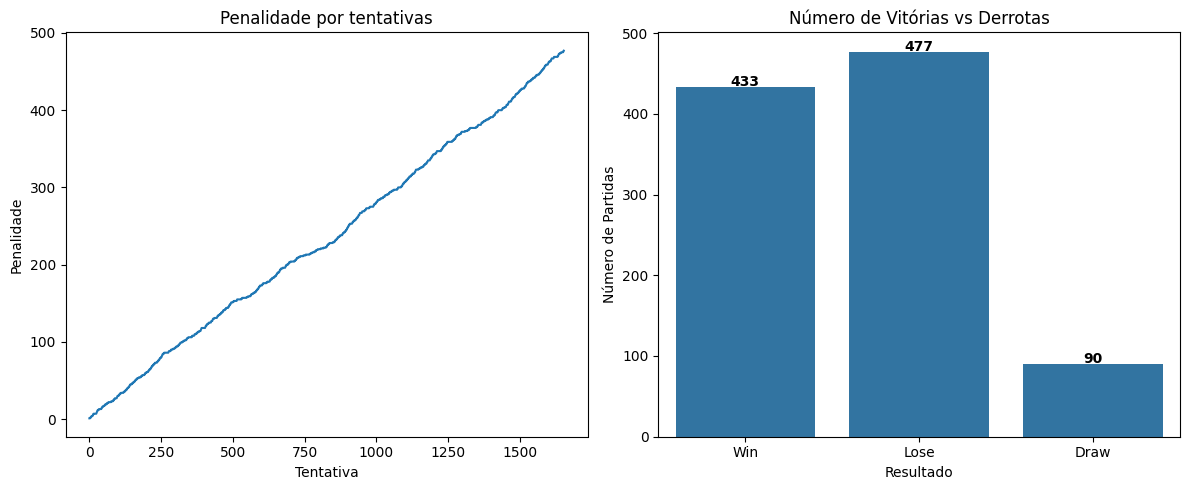

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

axs[0].set_title("Penalidade por tentativas")
axs[0].plot(range(len(agent.training_error)), agent.training_error)
axs[0].set_ylabel("Penalidade")
axs[0].set_xlabel("Tentativa")

# Criar os dados para o gráfico
data = {'Result': ['Win', 'Lose', 'Draw'], 'Count': [agent.win, agent.lose, n_episodes - (agent.win + agent.lose)]}

# Plotar o gráfico de barras usando seaborn
axs[1] = sns.barplot(x='Result', y='Count', data=data)

# Adicionar rótulos nas barras
for index, value in enumerate(data['Count']):
    axs[1].text(index, value + 1, str(value), ha='center', fontweight='bold')
    
# Adicionando legendas e rótulos
axs[1].set_xlabel("Resultado")
axs[1].set_ylabel("Número de Partidas")
axs[1].set_title("Número de Vitórias vs Derrotas")

plt.tight_layout()
plt.show()